In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
import plotnine as pl

In [30]:
data = pd.read_csv("global_power_plant_database.csv")

C:\Users\ola_w\AppData\Local\Temp\ipykernel_17184\2384226065.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


C:\Users\ola_w\AppData\Local\Temp\ipykernel_17184\3109169440.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


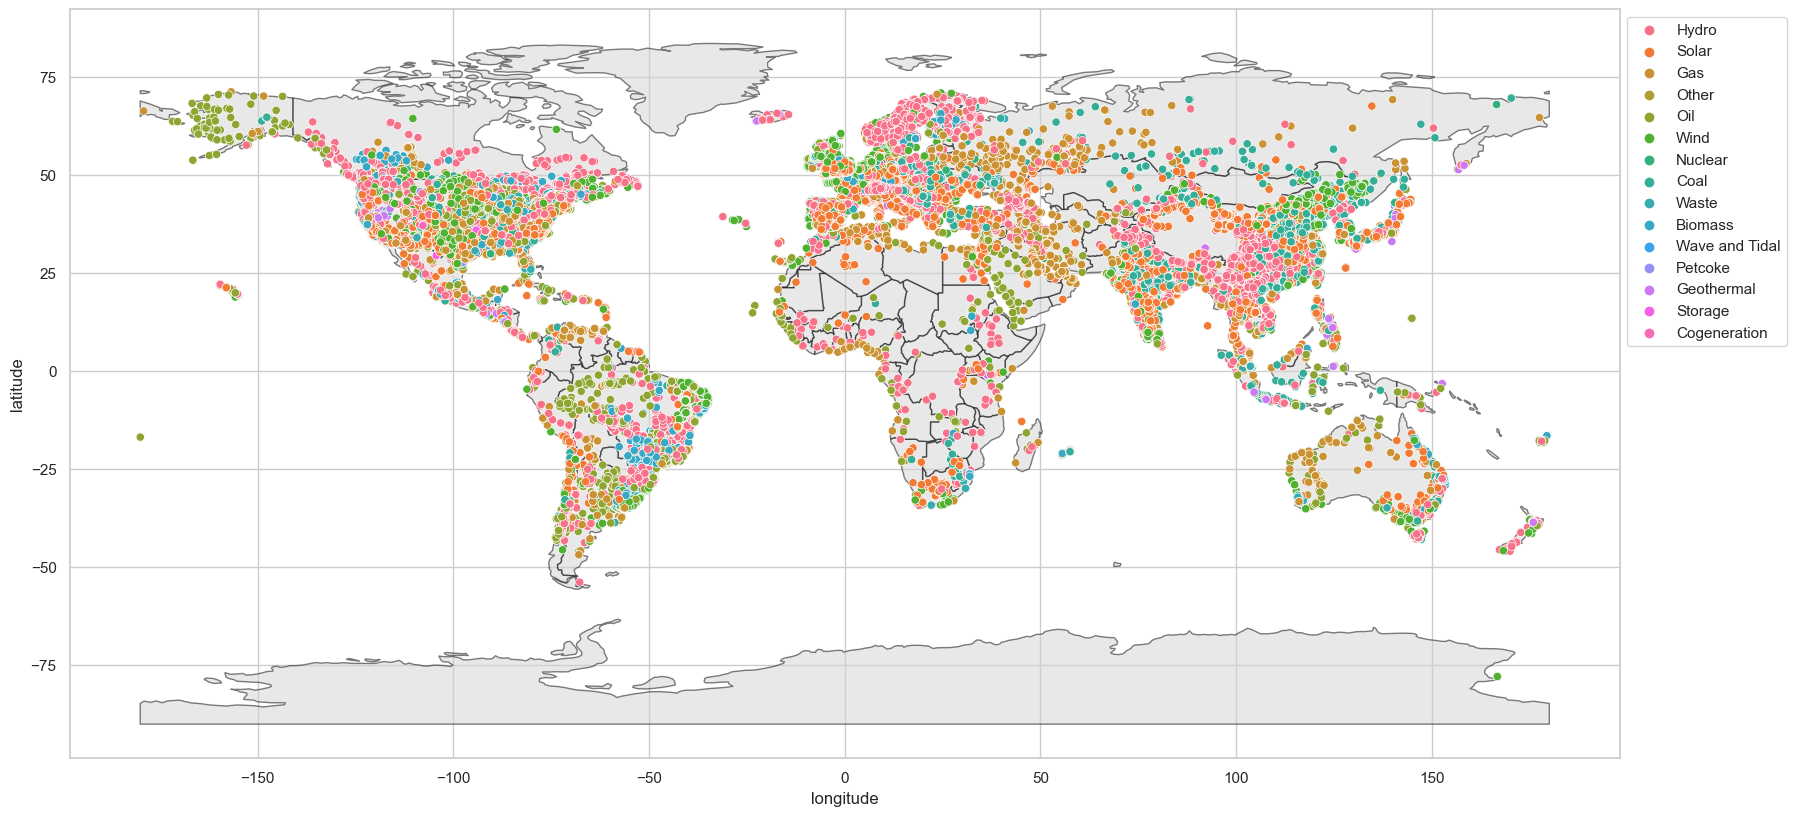

In [31]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
world.plot(
    ax=ax,
    color="lightgray",
    edgecolor="black",
    alpha=0.5
)
sns.scatterplot(data=data, y="latitude",x="longitude", hue="primary_fuel", legend="auto")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [32]:
set(data.primary_fuel)

{'Biomass',
 'Coal',
 'Cogeneration',
 'Gas',
 'Geothermal',
 'Hydro',
 'Nuclear',
 'Oil',
 'Other',
 'Petcoke',
 'Solar',
 'Storage',
 'Waste',
 'Wave and Tidal',
 'Wind'}

In [33]:
data.primary_fuel.value_counts()

primary_fuel
Solar             10665
Hydro              7156
Wind               5344
Gas                3998
Coal               2330
Oil                2320
Biomass            1430
Waste              1068
Nuclear             195
Geothermal          189
Storage             135
Other                43
Cogeneration         41
Petcoke              12
Wave and Tidal       10
Name: count, dtype: int64

## Generation capacity by country

In [34]:
capacities = {country : None for country in set(data["country"])}
for country in capacities.keys():
    swap = data["capacity_mw"].loc[data["country"] == country]
    capacities[country] = {"Capacity (MW)" : np.sum(swap), "Country" : country}

capacities = pd.DataFrame(capacities).T
capacities = capacities.sort_values(by="Capacity (MW)", ascending=False)
# capacities["Capacity (MW)"] = capacities["Capacity (MW)"].round(0)

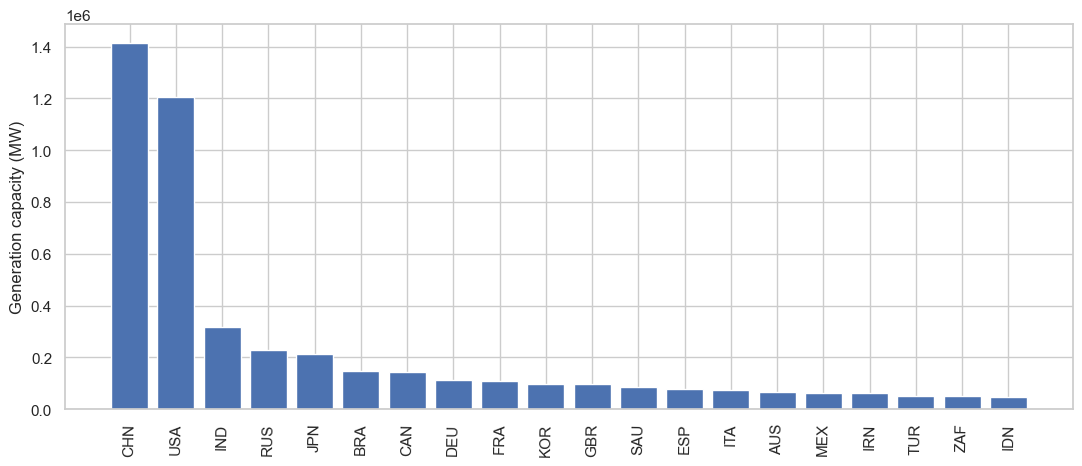

In [35]:
plt.figure(figsize=(13, 5))
plt.bar(capacities["Country"][:20], capacities["Capacity (MW)"][:20])
plt.xticks(rotation = 89)
plt.ylabel("Generation capacity (MW)")
plt.show()

In [36]:
for col in data:
    print(f"Column '\033[92m{col}\033[0m' has {np.sum(data[col].isna())} (\033[34m{np.sum(data[col].isna()) / len(data[col]):.2%}\033[0m) NA and {np.sum(data[col].isnull())} (\033[34m{np.sum(data[col].isnull()) / len(data[col]):.2%}\033[0m) missing values")

Column 'country' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'country_long' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'name' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'gppd_idnr' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'capacity_mw' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'latitude' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'longitude' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'primary_fuel' has 0 (0.00%) NA and 0 (0.00%) missing values
Column 'other_fuel1' has 32992 (94.44%) NA and 32992 (94.44%) missing values
Column 'other_fuel2' has 34660 (99.21%) NA and 34660 (99.21%) missing values
Column 'other_fuel3' has 34844 (99.74%) NA and 34844 (99.74%) missing values
Column 'commissioning_year' has 17489 (50.06%) NA and 17489 (50.06%) missing values
Column 'owner' has 14068 (40.27%) NA and 14068 (40.27%) missing values
Column 'source' has 15 (0.04%) NA and 15 (0.04%) missing values
Column 'url' has 18 (0.05%) NA

## ggplot demo 

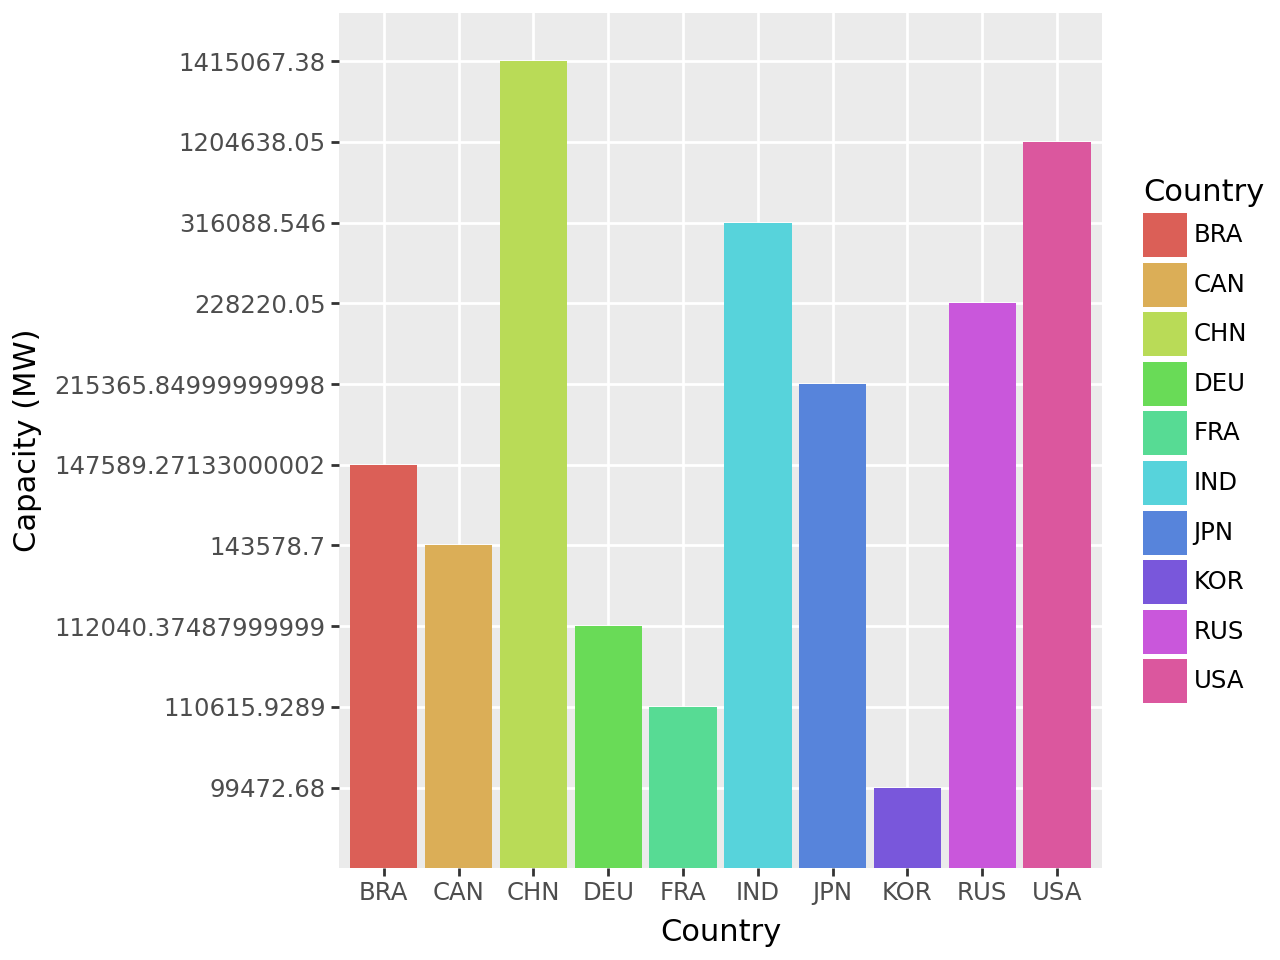

In [37]:
(
pl.ggplot(capacities.head(10)) +
    pl.aes(x="Country",y="Capacity (MW)",fill = "Country") +
    pl.geom_bar(stat="identity")
)

In [38]:
data["primary_fuel"].unique()

array(['Hydro', 'Solar', 'Gas', 'Other', 'Oil', 'Wind', 'Nuclear', 'Coal',
       'Waste', 'Biomass', 'Wave and Tidal', 'Petcoke', 'Geothermal',
       'Storage', 'Cogeneration'], dtype=object)

In [39]:
renewable_list = ('Hydro', 'Solar', 'Waste', 'Biomass', 'Wave and Tidal','Geothermal','Storage', 'Cogeneration','Wind')
# storage since I think it refers to pumped hydro and thermal solar storage

def is_renewable(x, ren):
    return True if x in ren else False

In [40]:
data["is_renewable"] = data["primary_fuel"].apply(is_renewable, ren = renewable_list)

<Axes: xlabel='Country'>

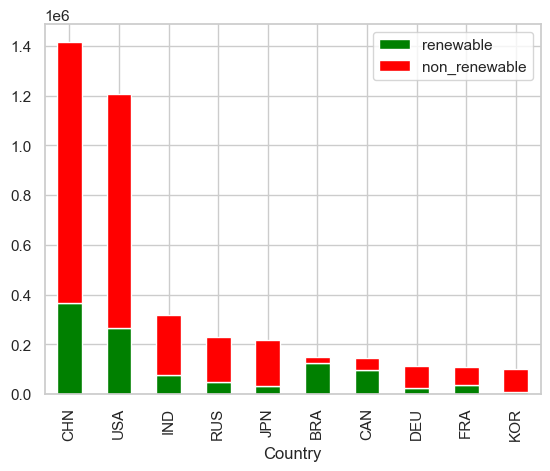

In [41]:
xtoplot = capacities["Country"][:10]

data_splot =  pd.DataFrame(index = xtoplot, columns=['renewable', 'non_renewable'])

for country in xtoplot:
    temp = data[data["country"]==country]
    data_splot.loc[country, 'renewable'] = temp[temp["is_renewable"]]["capacity_mw"].sum()
    data_splot.loc[country, 'non_renewable'] = temp[~temp["is_renewable"]]["capacity_mw"].sum()
    data_splot.loc[country, 'country'] = country

sns.set(style="whitegrid")
data_splot.plot(kind = 'bar', stacked=True, color = ['green', 'red'])



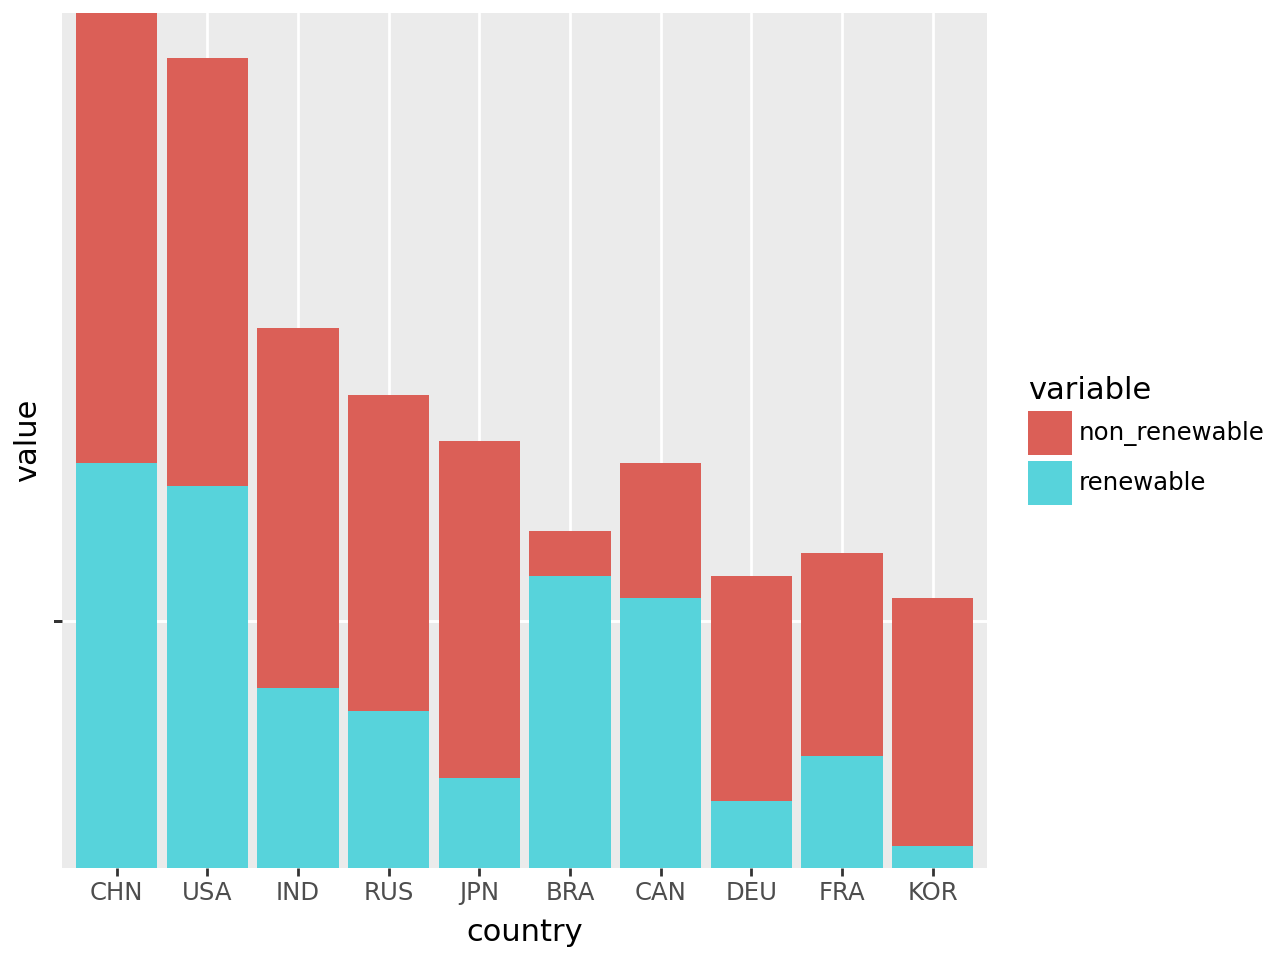

In [53]:
plot_df = pd.melt(data_splot, id_vars=["country"])
plot_df['country'] = pd.Categorical(plot_df['country'], categories=xtoplot)
plot_df['value'] = round(plot_df['value'], 0)

(pl.ggplot(plot_df, pl.aes("country", "value", fill = 'variable'))
 + pl.geom_col()
 + pl.scale_y_discrete(labels = [None for _ in range(len(set(plot_df["country"])))], breaks = [_ for _ in range(len(set(plot_df["country"])))])
 )

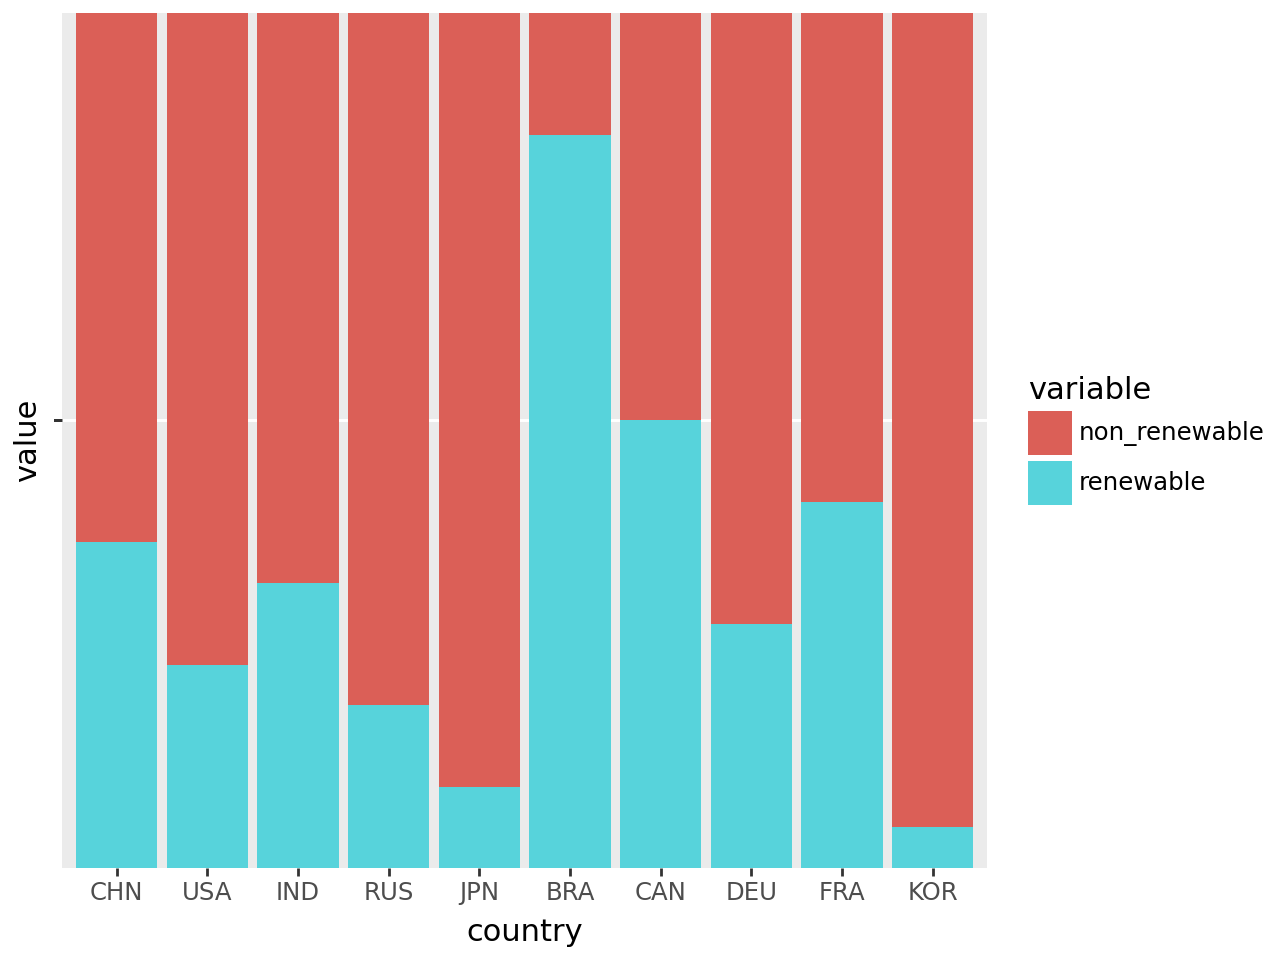

In [58]:
percent_data = data_splot.copy()
temp = percent_data["non_renewable"] + percent_data["renewable"]
percent_data["renewable"] /= temp
percent_data["non_renewable"] /= temp
percent_data.head()

percent_data = pd.melt(percent_data, id_vars=["country"])
percent_data['country'] = pd.Categorical(percent_data['country'], categories=xtoplot)


(pl.ggplot(percent_data, pl.aes("country", "value", fill = 'variable'))
 + pl.geom_col()
 + pl.scale_y_discrete(labels = [None for _ in range(len(set(plot_df["country"])))], breaks = [_ for _ in range(len(set(plot_df["country"])))])
 )